<a href="https://colab.research.google.com/github/johnmcdonnell/CategoryFlashcards/blob/master/Projects/vivian_health/notebooks/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define Model Training Pipeline

Objectives:

1. Transparent pipeline
2. Reproducibility
3. Ease of experimentation

## Packages

### Install External packages

In [1]:
!pip install ipytest transformers datasets wandb html2text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 365 kB 53.3 MB/s 
     |████████████████████████████████| 1.8 MB 17.1 MB/s 
     |████████████████████████████████| 297 kB 45.7 MB/s 
     |████████████████████████████████| 101 kB 7.3 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 6.6 MB 16.6 MB/s 
     |████████████████████████████████| 115 kB 32.4 MB/s 
     |████████████████████████████████| 212 kB 25.0 MB/s 
     |████████████████████████████████| 141 kB 9.1 MB/s 
     |████████████████████████████████| 127 kB 48.4 MB/s 
     |████████████████████████████████| 181 kB 69.0 MB/s 
     |████████████████████████████████| 157 kB 49.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 157 kB 60.7 MB/s 
     |██████████████████████████████

In [2]:
import pytest
import ipytest

import pandas as pd
from tqdm import tqdm
import numpy as np
import urllib
from datetime import date, timedelta
from itertools import permutations
import datetime
import string
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from IPython.display import Image
from IPython import get_ipython
import html2text

import torch
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import wandb


# Define pipeline

## Functions


### Device

In [3]:
def identify_tensor_device():
    if torch.backends.mps.is_available():
        device = "mps"
    elif torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"

    return device

### Fetch Data

In [4]:

def retrieve_data(path, index_column, method='filepath'):
    if method == 'filepath':
        data = pd.read_csv(path)
    else:
        raise NotImplementedError(f'Method {method} is not implemented.')
    
    assert data.shape[0] > 0, 'Data file has no rows'
    
    data = data.dropna(subset=[index_column]).set_index(index_column)

    return data

In [5]:

# Running these tests requires connecting to GDrive. Probably ideal 

ipytest.clean_tests()

path_data = '/content/drive/MyDrive/Vivian Project'

def test_retrieve_data_from_file():
    from google.colab import drive
    drive.mount('/content/drive')
    the_data = retrieve_data(f'{path_data}/tagged_job_descriptions.csv', 'job_id', method='filepath')
    assert isinstance(the_data, pd.DataFrame)


def test_retrieve_data_from_s3():
    with pytest.raises(Exception) as e_info:
        # Will decide how to do this in the future, for now should raise exception
        retrieve_data(f'{path_data}/tagged_job_descriptions.csv', 'job_id', method='s3')

ipytest.run('-qq')


..                                                                                           [100%]


<ExitCode.OK: 0>

### Preprocess

In [6]:
text_maker = html2text.HTML2Text()

def remove_html_tags(string):
    #return BeautifulSoup(string, "lxml").text
    return text_maker.handle(string)


def concatenate_title_with_description(row,
                                       title_col = 'job_title',
                                       description_col = 'description'):
    """Concatenates job title with the description, also removes HTML tags from description"""
    if pd.notnull(row[title_col]) and pd.notnull(row[description_col]):
        concatenated = f"""title: {row[title_col]}
        description: {remove_html_tags(row[description_col])}""".strip()
    elif pd.notnull(row[title_col]):
        concatenated = f"title: {row[title_col]}"
    elif pd.notnull(row[description_col]):
        concatenated = f"description: {remove_html_tags(row[description_col])}"
    else:
        concatenated = None
    return concatenated

def preprocess(data_df, text_column_name):
    data_df[text_column_name] = data_df.apply(concatenate_title_with_description, axis=1)
    
    return data_df




### Train / test split

In [7]:
def fetch_label_mapping(y_data):
    id2label = {i: name for i, name in enumerate(y_data.names)}
    label2id = {name: i for i, name in enumerate(y_data.names)}
    return id2label, label2id

def split(data, x_col_name, y_col_name, test_size=.33, random_state=42):
    label_is_not_null = data[y_col_name].notnull()
    labelled_data = data.loc[label_is_not_null, [x_col_name, y_col_name]]
    train_df, test_df = train_test_split(labelled_data,
                                         test_size=test_size,
                                         random_state=random_state)

    # Need to see the exact same classes in the train and test.
    assert set(train_df[y_col_name] == set(test_df[y_col_name]))

    dataset = datasets.DatasetDict({'train': datasets.Dataset.from_pandas(train_df),
                                'test': datasets.Dataset.from_pandas(test_df)
                                })
    
    dataset = dataset.rename_column(y_col_name, 'label')
    dataset = dataset.class_encode_column('label')

    id2label, label2id = fetch_label_mapping(dataset['train'].features['label'])

    return dataset, id2label, label2id

### Tokenize

In [8]:

def get_tokenizer(pretrained_model_name):
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    return tokenizer

def get_wrapped_tokenizer(tokenizer, max_sequence_length=512, tokenizer_kwargs={}):
    def tokenize_data(examples):
        if max_sequence_length is not None:
            encoding = tokenizer(examples['text'], **tokenizer_kwargs)
        else:
            encoding = tokenizer(examples['text'], **tokenizer_kwargs)
        encoding['token_count'] = [np.sum(x) for x in encoding['attention_mask']]
        if max_sequence_length is not None:
            encoding['is_max_count'] = [x == max_sequence_length for x in encoding['token_count']]
        return encoding
    return tokenize_data



### Fit Model

In [9]:
from transformers.utils.dummy_pt_objects import TRANSFO_XL_PRETRAINED_MODEL_ARCHIVE_LIST

def initialize_pretrained_model(dataset, pretrained_model_name, device,
                                id2label, label2id):
    model = AutoModelForSequenceClassification\
        .from_pretrained(pretrained_model_name,
                            num_labels=len(id2label),
                            id2label=id2label,
                            label2id=label2id)\
        .to(device)
    return model


accuracy_metric = datasets.load_metric('accuracy')

def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

def preds_to_fake_probs(preds):
    ilogit_preds = 1 / (1 + np.exp(-preds))
    ilogit_preds_normalized = ilogit_preds / np.sum(ilogit_preds, axis=1)[:, None]
    return ilogit_preds_normalized

auc_multiclass_metric = datasets.load_metric('roc_auc', 'multiclass')

def compute_auc(eval_pred):
    logits, labels = eval_pred
    scores = preds_to_fake_probs(logits)
    return auc_multiclass_metric.compute(prediction_scores=scores, references=labels, multi_class='ovr')


def train_model(data, pretrained_model_name, device, id2label, label2id,
                artifact_dir, compute_metrics, model_kwargs={}, training_kwargs={}, trainer_kwargs={}):
    
    model = initialize_pretrained_model(dataset, pretrained_model_name, device,
                                id2label, label2id)

    training_args = TrainingArguments(output_dir=artifact_dir, **training_kwargs)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data['train'],
        eval_dataset=data['test'],
        compute_metrics=compute_metrics,
    )

    return trainer


In [10]:
def get_predictions(trainer, data):
    predictions, label_ids, metrics = trainer.predict(data)
    return predictions, label_ids, metrics

In [11]:

def threshold_curve(preds, label_ids, n_ntiles=10):
    correct = np.argmax(preds, axis=1) == label_ids
    fake_probs = preds_to_fake_probs(preds)
    confidences = np.max(fake_probs, axis=1)
    ntile, bins = pd.qcut(confidences, n_ntiles, labels=False, retbins=True)

    results = []
    for i in range(n_ntiles):
        count = np.sum(ntile >= i)
        accuracy = np.mean(correct[ntile >= i])
        results.append({'ntile': i,
                      'proportion': count / len(preds),
                      'accuracy': accuracy})
    return pd.DataFrame(results)


In [12]:


def evaluation(labels,predictions):
    return metrics

def get_stats_predictions(predictions):
    return stats

def quality_training(metrics,stats):
    return decision

def quality_process(stats):
    return decision

def read_artifact(path_artifacts, file_name):
    artifact = read(path_artifacts+file_name)
    
def save_artifact(path_artifacts, file_name):
    save(path_artifacts+file_name)
    
def push_predictions(path_data, file_name, predictions, method=None,):
    save(predictions)

# Training and Validation Pipeline

In [ ]:
Image(filename='train_test_vivian.png')

FileNotFoundError: ignored

## Parameters

In [25]:
context = 'gdrive'
project_name = 'vivian-shift-finetune'
run_name = 'deberta-fulldata-001'


In [26]:
if context == 'local':
    # # Establish paths
    path_project = '/Users/mendes/Koya-Tech/Projects/Vivian-Health/'
    path_data = path_project+'data/'
elif context == 'gdrive':
    from google.colab import drive
    drive.mount('/content/drive')

    path_data = '/content/drive/MyDrive/Vivian Project'
    path_output = '/content/drive/MyDrive/Vivian Project/Transformer Fine Tuning'
    path_artifact = f'/content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/{run_name}'
else:
    path_data = "/dbfs/FileStore/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
path_datafile = f'{path_data}/tagged_job_descriptions.csv'

index_column = 'job_id'
text_column_name = 'text'
y_col = 'shift'

pretrained_model_name = 'microsoft/deberta-base'

max_sequence_length = None

# BERT kwargs
tokenizer_kwargs = {
    'padding': 'max_length',
    'truncation': True
}

# XLNet kwargs
#tokenizer_kwargs = {
#    'return_tensors': 'pt'
#}


training_args = {'evaluation_strategy': 'epoch',
                 'num_train_epochs': 3,
                 'report_to': 'wandb',
                 'run_name': run_name}


config = {
    'project_name': project_name,
    'run_name': run_name,
    'path_datafile': path_datafile,
    'index_column': index_column,
    'text_column_name': text_column_name,
    'y_col': y_col,
    'pretrained_model_name': pretrained_model_name,
    'tokenizer_args': tokenizer_kwargs,
    'training_args_passed_in': training_args,
    'max_sequence_length': max_sequence_length
}



In [28]:
device = identify_tensor_device()

print(f"Using device: {device}")

Using device: cuda


In [29]:
if 'run' in globals():
    # If this is reinitialization, let wandb know we're done with the old run.
    run.finish()

run = wandb.init(project=project_name, entity="koya-test2", name=run_name, config=config, reinit=True)


eval/accuracy,▁▁
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▂▂▃▄▄▄▅▅▆▇▇██
train/global_step,▁▂▂▃▄▄▄▅▅▆▇▇██
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▇▃▄▂▅▅▁▃▄▅▄
eval/accuracy,0.3536
eval/loss,1.45898


wandb: Currently logged in as: jvmcdonnell-koya (koya-test2). Use `wandb login --relogin` to force relogin


In [30]:
#retrieve data

data = retrieve_data(path_datafile, index_column, method='filepath')


In [31]:
# Downsample for testing
#data = data.sample(n=2000)

In [32]:
%%time

#preprocessing


data_preprocessed = preprocess(data, text_column_name)
dataset, id2label, label2id = split(data_preprocessed, text_column_name, y_col, test_size=.33, random_state=42)


Casting to class labels:   0%|          | 0/24 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

CPU times: user 1min 55s, sys: 965 ms, total: 1min 56s
Wall time: 2min 3s


In [36]:
%%time

tokenizer = get_tokenizer(pretrained_model_name)
tokenize_data = get_wrapped_tokenizer(tokenizer, tokenizer_kwargs=tokenizer_kwargs)
dataset = dataset.map(tokenize_data, batched=True)

https://huggingface.co/microsoft/deberta-base/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgvg0dptp


storing https://huggingface.co/microsoft/deberta-base/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/c2bc27a1c7529c177696ff76b1e74cba8667be14e202359f20f9114e407f43e2.a39abb1c6179fb264c2db685f9a056b7cb8d4bc48d729888d292a2280debf8e2
creating metadata file for /root/.cache/huggingface/transformers/c2bc27a1c7529c177696ff76b1e74cba8667be14e202359f20f9114e407f43e2.a39abb1c6179fb264c2db685f9a056b7cb8d4bc48d729888d292a2280debf8e2
https://huggingface.co/microsoft/deberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp0r3py3m6


storing https://huggingface.co/microsoft/deberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
creating metadata file for /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps":

storing https://huggingface.co/microsoft/deberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/ce0ac094af27cf80bbf403595a6d47f1fc632981bf1d4c5bf69968568cbea410.e8ad27cc324bb0dc448d4d95f63e48f72688fb318a4c4c3f623485621b0b515c
creating metadata file for /root/.cache/huggingface/transformers/ce0ac094af27cf80bbf403595a6d47f1fc632981bf1d4c5bf69968568cbea410.e8ad27cc324bb0dc448d4d95f63e48f72688fb318a4c4c3f623485621b0b515c
https://huggingface.co/microsoft/deberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpctrvdgut


storing https://huggingface.co/microsoft/deberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/05056f257c8d2b63ad16fd26f847c9ab9ee34e33cdfad926e132be824b237869.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/05056f257c8d2b63ad16fd26f847c9ab9ee34e33cdfad926e132be824b237869.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/ce0ac094af27cf80bbf403595a6d47f1fc632981bf1d4c5bf69968568cbea410.e8ad27cc324bb0dc448d4d95f63e48f72688fb318a4c4c3f623485621b0b515c
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/05056f257c8d2b63ad16fd26f847c9ab9ee34e33cdfad926e132be824b237869.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file http

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

CPU times: user 1min 44s, sys: 2 s, total: 1min 46s
Wall time: 1min 6s


In [37]:

#training

trainer = train_model(dataset, pretrained_model_name, device, id2label, label2id,
        path_output, compute_accuracy, training_kwargs=training_args
        )

loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Days",
    "1": "Evenings",
    "2": "Flexible",
    "3": "Nights",
    "4": "Not Listed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Days": 0,
    "Evenings": 1,
    "Flexible": 2,
    "Nights": 3,
    "Not Listed": 4
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act"

storing https://huggingface.co/microsoft/deberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/dde0725208c11536042f6f416c538792d44a2d57d1ae399bbd1bc5867e02c465.0a3ec262cb3d4f634c72ce55f2766bb88771e6499b2512830e2e63bf19dbf97a
creating metadata file for /root/.cache/huggingface/transformers/dde0725208c11536042f6f416c538792d44a2d57d1ae399bbd1bc5867e02c465.0a3ec262cb3d4f634c72ce55f2766bb88771e6499b2512830e2e63bf19dbf97a
loading weights file https://huggingface.co/microsoft/deberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/dde0725208c11536042f6f416c538792d44a2d57d1ae399bbd1bc5867e02c465.0a3ec262cb3d4f634c72ce55f2766bb88771e6499b2512830e2e63bf19dbf97a
Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predict

In [40]:
trainer.train()

Loading model from /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-10500.
There were missing keys in the checkpoint model loaded: ['deberta.embeddings.position_ids', 'deberta.embeddings.word_embeddings.weight', 'deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.0.attention.self.q_bias', 'deberta.encoder.layer.0.attention.self.v_bias', 'deberta.encoder.layer.0.attention.self.in_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.0.attention.output.dense.weight', 'deberta.encoder.layer.0.attention.output.dense.bias', 'deberta.encoder.layer.0.attention.output.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.LayerNorm.bias', 'deberta.encoder.layer.0.intermediate.dense.weight', 'deberta.encoder.layer.0.intermediate.dense.bias', 'deberta.encoder.laye

ValueError: ignored

In [39]:
# Getting predictions
predictions, label_ids, metrics = get_predictions(trainer, dataset['test'])

The following columns in the test set don't have a corresponding argument in `DebertaForSequenceClassification.forward` and have been ignored: is_max_count, job_id, token_count, text. If is_max_count, job_id, token_count, text are not expected by `DebertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 11742
  Batch size = 8


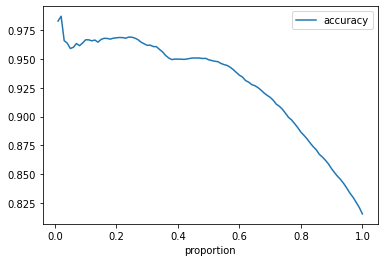

In [41]:
# Plotting threshold curve

threshold_curve(predictions, label_ids, n_ntiles=100).plot(x='proportion', y='accuracy')

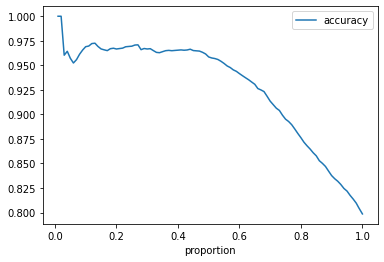

In [51]:
# Does it make a difference if we drop observations past the token limit?
not_max_count = ~ pd.Series(dataset['test']['is_max_count'])
threshold_curve(predictions[not_max_count], label_ids[not_max_count], n_ntiles=100).plot(x='proportion', y='accuracy')

In [31]:

# Writing artifact

trainer.save_model(path_artifact)
trainer.save_state() # I'm not 100% clear what this does.

Saving model checkpoint to /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/bert-fulldata-002
Configuration saved in /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/bert-fulldata-002/config.json
Model weights saved in /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/bert-fulldata-002/pytorch_model.bin


In [32]:
# Writing artifact to wandb

artifact = wandb.Artifact('fitted_model', type='fitted_model')
artifact.add_dir(path_artifact)
run.log_artifact(artifact)


wandb: Adding directory to artifact (/content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/bert-fulldata-002)... Done. 3.1s


In [ ]:
# NOT YET IMPLEMENTED


train_stats = get_stats_predictions(training_predictions)

training_decision = quality_training(training_metrics,train_stats)

training_decision_stats = quality_process(train_stats)

if training_decision in ['Good','Great']:
    print('trigger test')
else:
    print('trigger retrain')

#testing

X_test = preprocessing_x_data(X_test,preprosser_x_data)
y_test = preprocessing_y_data(y_test,preprosser_y_data)

test_predictions = prediction(X_test,model)

test_stats = get_stats_predictions(test_predictions)

test_metrics = evaluation(y_test,test_predictions)

test_decision = quality_training(test_metrics,test_stats)

test_decision_stats = quality_process(test_stats)

if test_decision in ['Good','Great']:
    print('trigger save artifacts')
    #save artifacts
    save_artifact(path_artifacts,file_name,preprosser_x_data)
    save_artifact(path_artifacts,file_name,preprosser_y_data)
    save_artifact(path_artifacts,file_name,model)
    save_artifact(path_artifacts,file_name,test_metrics)
    save_artifact(path_artifacts,file_name,test_stats)
else:
    print('trigger retrain')
    


## Production pipeline

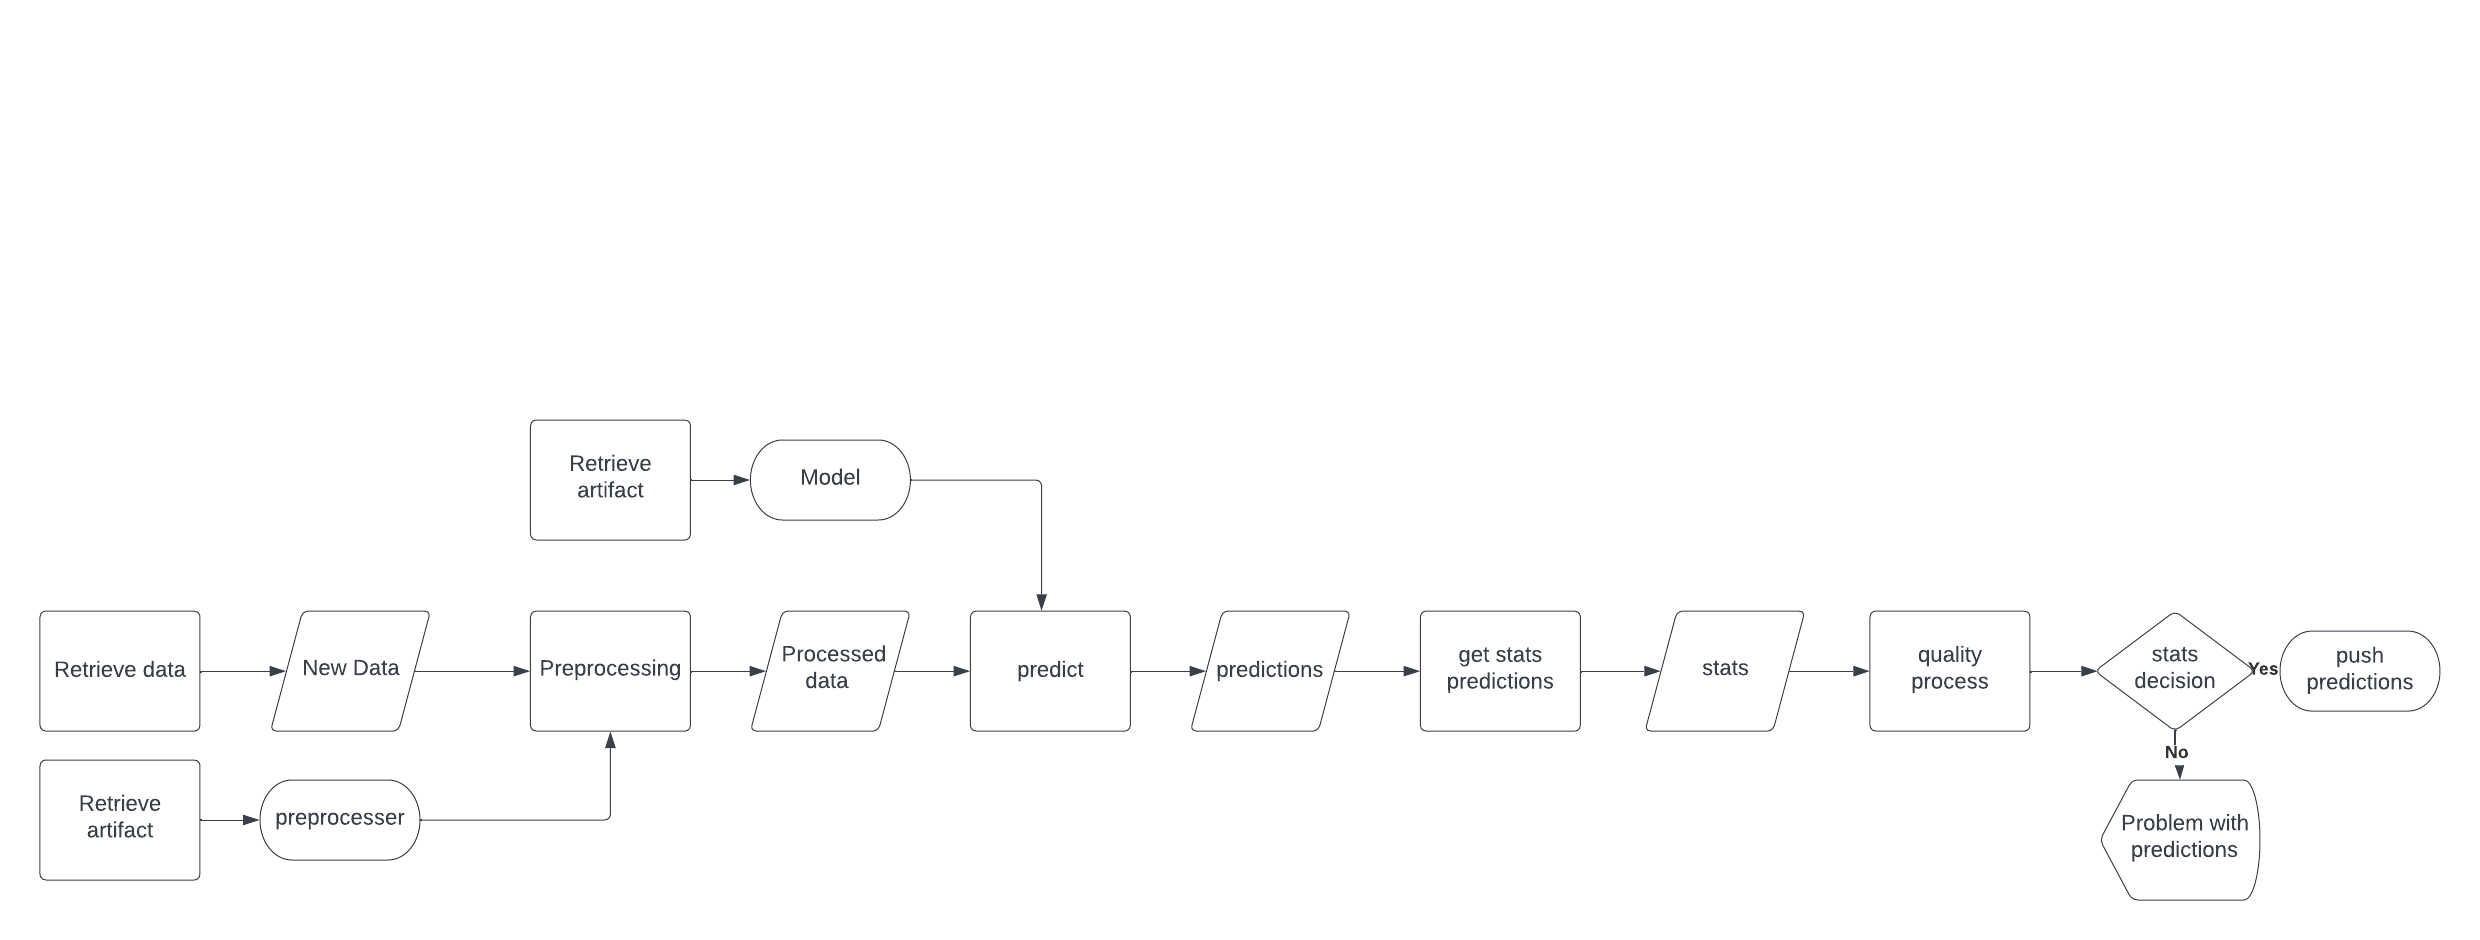

In [ ]:
Image(filename='vivianproduction.png')

In [ ]:
data = retrive_data(path_data,file_name,method=None)

preprosser_x_data = read_artifact(path_artifacts,file_name)
X_data = preprocessing_x_data(data,preprosser_x_data)

model = read_artifact(path_artifacts,file_name)
predictions = prediction(X_data,model)

stats = get_stats_predictions(predictions)

decision_stats = quality_process(stats)

if test_decision in ['Good','Great']:
    print('trigger push predictions')
    push_predictions(path_data,file_name,method=None,predictions)
else:
    print('trigger problem on stats')

# Things to explore

## Convenience functions

* Change this into a library with an executable script. Create a YAML file to send to the script to do a run.
* For exploration, create a notebook where you point it at a wandb run and it pulls the data and artifacts to enable diagnosis.
* More metrics and evaluation, e.g. summary statistics of fit outcomes.


## Model performance

* I suspect the text doesn't always have the information needed. In those cases, let's find out how to get it.
* Try alternate models e.g. albert
* Improve parameters, possibly hyperparameter search.
* Better handling of truncation. 
* Fine tune GPT-3 on this problem, or even just use GPT-3 embeddings as features.
* Second order classifier model such as xgboost to augment with things like regexes.

### Ideas for handling truncation

* Chunk the text, evaluate each chunk take the most confident prediction across all
* Chunk the text, evaluate each chunk, average the model weights and take the best.
* Build a second order model that takes multiple chunks into account
* Use an architecture with longer sequence length such as longformer
